# Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# seaborn
#!conda install -c anaconda seaborn --yes
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 1. Prepare Data

## 1.1 Obtain Toronto FSA data

### 1.1a List of Toronto FSA codes
Data source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [ ]:
# Only run for first time.
# Extract FSA information from wiki page, and save to csv file. 

#!pip install beautifulsoup4 
from bs4 import BeautifulSoup
import urllib.request, urllib.parse, urllib.error
import ssl

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urllib.request.urlopen(url, context=ctx).read()
soup = BeautifulSoup(html, 'html.parser')

table = soup.find_all('table')[0] # Grab the first table

df = pd.DataFrame(columns=range(0,3)) 

row_marker = 0
for row in table.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        df.loc[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker+=1

df.columns = ['FSA', 'Borough', 'Nb']                       # Rename column head
df.replace(to_replace='\\n', value="", regex=True, inplace=True)   # Replace \n columns

df=df[df['Borough']!="Not assigned"].dropna()                      # Filter out Borough = "Not assigned"

fsa_df = df.groupby(['FSA', 'Borough']).count()
fsa_df=fsa_df.drop('Nb', axis=1).reset_index()
fsa_df.to_csv(r'toronto_fsa.csv',index=False)

In [2]:
fsa_df = pd.read_csv('toronto_fsa.csv')
print('dataframe: fsa_df,   shape:', fsa_df.shape)
fsa_df.head(3)

dataframe: fsa_df,   shape: (103, 2)


FSA      Borough
0  M1B  Scarborough
1  M1C  Scarborough
2  M1E  Scarborough

### 1.1b Toronto FSA geolocations
Data source: http://cocl.us/Geospatial_data

In [3]:
geo_df = pd.read_csv('Geospatial_Coordinates.csv')
geo_df.rename(columns={"Postal Code":"FSA"}, inplace = True)
print('dataframe: geo_df,   shape:', geo_df.shape)
geo_df.head(3)

dataframe: geo_df,   shape: (103, 3)


FSA   Latitude  Longitude
0  M1B  43.806686 -79.194353
1  M1C  43.784535 -79.160497
2  M1E  43.763573 -79.188711

### 1.1c Toronto FSA populations
Data source: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A

<!--
https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/page_dl-tc.cfm?Lang=E
//-->

In [4]:
pop_df = pd.read_csv('population.csv')
print('dataframe: pop_df,   shape:', pop_df.shape)
pop_df.head(3)

dataframe: pop_df,   shape: (523, 3)


FSA Province  Population
0  K0A  Ontario      103474
1  K0B  Ontario       20945
2  K0C  Ontario       52154

### 1.1 Result: Combine dataframe

In [5]:
df = pd.merge(fsa_df, pop_df[['FSA','Population']], on='FSA')
df = pd.merge(df, geo_df, on='FSA')
print('dataframe: df,   shape:', df.shape)
df.head(3)

dataframe: df,   shape: (102, 5)


FSA      Borough  Population   Latitude  Longitude
0  M1B  Scarborough       66108  43.806686 -79.194353
1  M1C  Scarborough       35626  43.784535 -79.160497
2  M1E  Scarborough       46943  43.763573 -79.188711

## 1.2 Explore Restaurants in Toronto

<!--
CLIENT_ID = 'I2GDHXDCPDKU5WXYUPJWM551N3JVWEFK0WOZFHYQAVRFEHW3' # your Foursquare ID
CLIENT_SECRET = 'WJV00LZPAEDAJ4OWDUHSEA5FEXBYN4YCHKGUFCCOKRKJC3Z4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
//-->

In [ ]:
# Only run for first time
# Foursquare credentials

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### 1.2a Obtain list of venues from Foursquare

In [ ]:
# Only run for first time
# To obtain the list of venues directly from foursquare and save to venues.csv

# function for loop through FSA to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['FSA', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

venues = getNearbyVenues(names=df['FSA'], latitudes=df['Latitude'], longitudes=df['Longitude'])
venues.to_csv(r'venues.csv',index=False)

In [6]:
venues = pd.read_csv('venues.csv')
print('dataframe: venues,   shape:', venues.shape)
venues.head(3)

dataframe: venues,   shape: (2205, 7)


FSA   Latitude  Longitude                        Venue  Venue Latitude  \
0  M3A  43.753259 -79.329656              Brookbanks Park       43.751976   
1  M3A  43.753259 -79.329656  Careful & Reliable Painting       43.752622   
2  M3A  43.753259 -79.329656                Variety Store       43.751974   

   Venue Longitude              Venue Category  
0       -79.332140                        Park  
1       -79.331957  Construction & Landscaping  
2       -79.333114           Food & Drink Shop

### 1.2b Retrieve Categories in Foursquare
Data source: https://developer.foursquare.com/docs/api/venues/categories <br />
Web format (for view): https://developer.foursquare.com/docs/resources/categories

In [ ]:
# Only run for first time
# To get the categories list from foursquare and save as foursq_cat.csv

# create URL and obtain the json
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}&m=foursquare'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
foursq_cat_json = requests.get(url).json()

# instantiate the dataframe with defined columns
column_names = ['id', 'cat_name', 'cat1', 'cat2'] 
foursq_cat_df = pd.DataFrame(columns=column_names)
foursq_cat_df

# get data from foursq_cat_json
for data1 in foursq_cat_json['response']['categories']:
    id = data1['id']
    cat1 = data1['name']
    foursq_cat_df = foursq_cat_df.append({'id': id, 'cat_name': cat1, 'cat1': cat1, 'cat2': cat1}, ignore_index=True)
    for data2 in data1['categories']:
        if (data2):
            id = data2['id']
            cat2 = data2['name']
            foursq_cat_df = foursq_cat_df.append({'id': id, 'cat_name': cat2, 'cat1': cat1, 'cat2': cat2}, ignore_index=True)
        for data3 in data2['categories']:
            if (data3):
                id = data3['id']
                cat_name = data3['name']
                foursq_cat_df = foursq_cat_df.append({'id': id, 'cat_name': cat_name, 'cat1': cat1, 'cat2': cat2}, ignore_index=True)

foursq_cat_df.rename(columns={"cat_name":"Venue Category"}, inplace = True)
foursq_cat_df.to_csv(r'foursq_cat.csv',index=False)

In [7]:
foursq_cat_df = pd.read_csv('foursq_cat.csv')
print('dataframe: foursq_cat_df,   shape:', foursq_cat_df.shape)
foursq_cat_df.head(3)

dataframe: foursq_cat_df,   shape: (833, 4)


id        Venue Category                  cat1  \
0  4d4b7104d754a06370d81259  Arts & Entertainment  Arts & Entertainment   
1  56aa371be4b08b9a8d5734db          Amphitheater  Arts & Entertainment   
2  4fceea171983d5d06c3e9823              Aquarium  Arts & Entertainment   

                   cat2  
0  Arts & Entertainment  
1          Amphitheater  
2              Aquarium

### 1.2 Result: Dataframe on venue of restaurants only

In [8]:
foods = pd.merge(venues, foursq_cat_df[['cat1','Venue Category']], on='Venue Category')
foods = foods[foods['cat1']=='Food']
print('dataframe: foods,   shape:', foods.shape)
foods.head(3)

dataframe: foods,   shape: (1203, 8)


FSA   Latitude  Longitude          Venue  Venue Latitude  Venue Longitude  \
62  M4A  43.725882 -79.315572    Tim Hortons       43.725517       -79.313103   
63  M5A  43.654260 -79.360636  Tandem Coffee       43.653559       -79.361809   
64  M5A  43.654260 -79.360636           Arvo       43.649963       -79.361442   

   Venue Category  cat1  
62    Coffee Shop  Food  
63    Coffee Shop  Food  
64    Coffee Shop  Food

## 1.3 Top 10 food venues by FSA

In [9]:
# one hot encoding
onehot = pd.get_dummies(foods[['Venue Category']], prefix="", prefix_sep="")

# add FSA column back to dataframe
onehot['FSA'] = foods['FSA'] 

# move FSA column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

# group
food_grouped = onehot.groupby('FSA').mean().reset_index()

print('dataframe: food_grouped,   shape:', food_grouped.shape)
food_grouped.head(3)

dataframe: food_grouped,   shape: (79, 82)


FSA  Afghan Restaurant  American Restaurant  Asian Restaurant  BBQ Joint  \
0  M1B                0.0                  0.0               0.0        0.0   
1  M1E                0.0                  0.0               0.0        0.0   
2  M1G                0.0                  0.0               0.0        0.0   

   Bagel Shop  Bakery  Belgian Restaurant  Bistro  Breakfast Spot  \
0         0.0     0.0                 0.0     0.0        0.000000   
1         0.0     0.0                 0.0     0.0        0.333333   
2         0.0     0.0                 0.0     0.0        0.000000   

   Bubble Tea Shop  Burger Joint  Burrito Place  Cafeteria  Café  \
0              0.0           0.0            0.0        0.0   0.0   
1              0.0           0.0            0.0        0.0   0.0   
2              0.0           0.0            0.0        0.0   0.0   

   Cajun / Creole Restaurant  Caribbean Restaurant  Chinese Restaurant  \
0                        0.0                   0.0                 0.0   
1                        0.0                   0.0                 0.0   
2                        0.0                   0.0                 0.0   

   Coffee Shop  Comfort Food Restaurant  Creperie  Cuban Restaurant  \
0     0.000000                      0.0       0.0               0.0   
1     0.000000                      0.0       0.0               0.0   
2     0.666667                      0.0       0.0               0.0   

   Cupcake Shop  Deli / Bodega  Dessert Shop  Diner  Doner Restaurant  \
0           0.0            0.0           0.0    0.0               0.0   
1           0.0            0.0           0.0    0.0               0.0   
2           0.0            0.0           0.0    0.0               0.0   

   Donut Shop  Dumpling Restaurant  Eastern European Restaurant  \
0         0.0                  0.0                          0.0   
1         0.0                  0.0                          0.0   
2         0.0                  0.0                          0.0   

   Empanada Restaurant  Ethiopian Restaurant  Falafel Restaurant  \
0                  0.0                   0.0                 0.0   
1                  0.0                   0.0                 0.0   
2                  0.0                   0.0                 0.0   

   Fast Food Restaurant  Filipino Restaurant  Fish & Chips Shop  Food  \
0                   1.0                  0.0                0.0   0.0   
1                   0.0                  0.0                0.0   0.0   
2                   0.0                  0.0                0.0   0.0   

   Food Court  Food Truck  French Restaurant  Fried Chicken Joint  \
0         0.0         0.0                0.0                  0.0   
1         0.0         0.0                0.0                  0.0   
2         0.0         0.0                0.0                  0.0   

   Frozen Yogurt Shop  Gastropub  German Restaurant  Gluten-free Restaurant  \
0                 0.0        0.0                0.0                     0.0   
1                 0.0        0.0                0.0                     0.0   
2                 0.0        0.0                0.0                     0.0   

   Greek Restaurant  Hotpot Restaurant  Ice Cream Shop  Indian Restaurant  \
0               0.0                0.0             0.0                0.0   
1               0.0                0.0             0.0                0.0   
2               0.0                0.0             0.0                0.0   

   Indonesian Restaurant  Irish Pub  Italian Restaurant  Japanese Restaurant  \
0                    0.0        0.0                 0.0                  0.0   
1                    0.0        0.0                 0.0                  0.0   
2                    0.0        0.0                 0.0                  0.0   

   Juice Bar  Korean Restaurant  Latin American Restaurant  Malay Restaurant  \
0        0.0           0.000000                        0.0               0.0   
1        0.0           0.000000           

In [10]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

# create columns according to number of top venues
columns = ['FSA']
for ind in np.arange(num_top_venues):
    columns.append('Top {} Food Venue'.format(ind+1))

# create a new dataframe
FSA_top_venue = pd.DataFrame(columns=columns)
FSA_top_venue['FSA'] = food_grouped['FSA']

for ind in np.arange(food_grouped.shape[0]):
    FSA_top_venue.iloc[ind, 1:] = return_most_common_venues(food_grouped.iloc[ind, :], num_top_venues)

print('dataframe: FSA_top_venue,   shape:', FSA_top_venue.shape)
FSA_top_venue.head(3)

dataframe: FSA_top_venue,   shape: (79, 11)


FSA      Top 1 Food Venue   Top 2 Food Venue             Top 3 Food Venue  \
0  M1B  Fast Food Restaurant        Wings Joint  Eastern European Restaurant   
1  M1E    Mexican Restaurant        Pizza Place               Breakfast Spot   
2  M1G           Coffee Shop  Korean Restaurant                  Wings Joint   

              Top 4 Food Venue Top 5 Food Venue Top 6 Food Venue  \
0                 Cupcake Shop    Deli / Bodega     Dessert Shop   
1  Eastern European Restaurant     Cupcake Shop    Deli / Bodega   
2  Eastern European Restaurant    Deli / Bodega     Dessert Shop   

  Top 7 Food Venue  Top 8 Food Venue  Top 9 Food Venue    Top 10 Food Venue  
0            Diner  Doner Restaurant        Donut Shop  Dumpling Restaurant  
1     Dessert Shop             Diner  Doner Restaurant           Donut Shop  
2            Diner  Doner Restaurant        Donut Shop  Dumpling Restaurant

## 1.4 Venue Cat Count by FSA on top 10 venues

In [11]:
Top_foods = foods[['Venue Category','cat1']].groupby('Venue Category').count().reset_index().rename(columns={"cat1":"Count"}).sort_values(by=['Count'], ascending=False).head(10)['Venue Category'].tolist()
columns = ['FSA']
for i in Top_foods:
    columns.append(i)
columns

['FSA',
 'Coffee Shop',
 'Café',
 'Restaurant',
 'Pizza Place',
 'Italian Restaurant',
 'Bakery',
 'Sandwich Place',
 'Japanese Restaurant',
 'Fast Food Restaurant',
 'Burger Joint']

In [12]:
# one hot encoding
onehot = pd.get_dummies(foods[['Venue Category']], prefix="", prefix_sep="")

# add FSA column back to dataframe
onehot['FSA'] = foods['FSA'] 

# move FSA column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

# group
food_cat = onehot.groupby('FSA').sum().reset_index()
food_cat = food_cat[columns]
food_cat.set_index('FSA', inplace = True)

print('dataframe: food_cat,   shape:', food_cat.shape)
food_cat.head(3)

dataframe: food_cat,   shape: (79, 10)


Coffee Shop  Café  Restaurant  Pizza Place  Italian Restaurant  Bakery  \
FSA                                                                           
M1B            0     0           0            0                   0       0   
M1E            0     0           0            1                   0       0   
M1G            2     0           0            0                   0       0   

     Sandwich Place  Japanese Restaurant  Fast Food Restaurant  Burger Joint  
FSA                                                                           
M1B               0                    0                     1             0  
M1E               0                    0                     0             0  
M1G               0                    0                     0             0

# 2. Visualization

## 2.1 Food Venues in Toronto

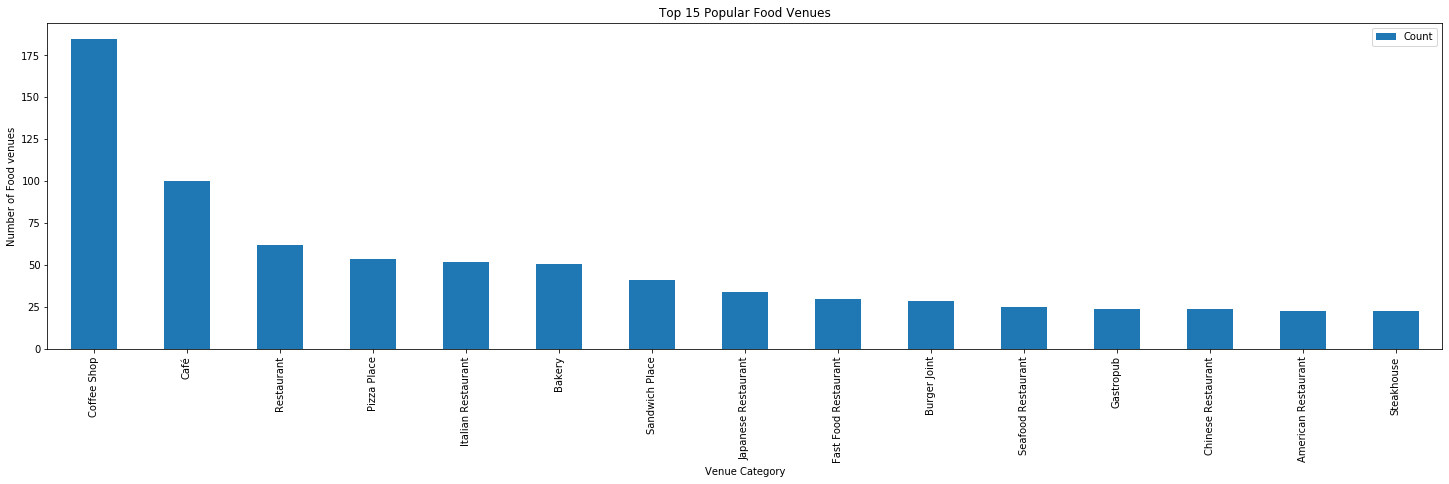

In [13]:
venue_count = foods[['FSA','Venue Category']].groupby('Venue Category').count().rename(columns={"FSA":"Count"})
venue_count.sort_values(by='Count', ascending =False, inplace=True)
venue_count.head(15).plot(kind='bar', figsize=(25, 6))

plt.xlabel('Venue Category') # add to x-label to the plot
plt.ylabel('Number of Food venues') # add y-label to the plot
plt.title('Top 15 Popular Food Venues') # add title to the plot

plt.show()

## 2.2 Food Venues by FSAs

### Bar chart

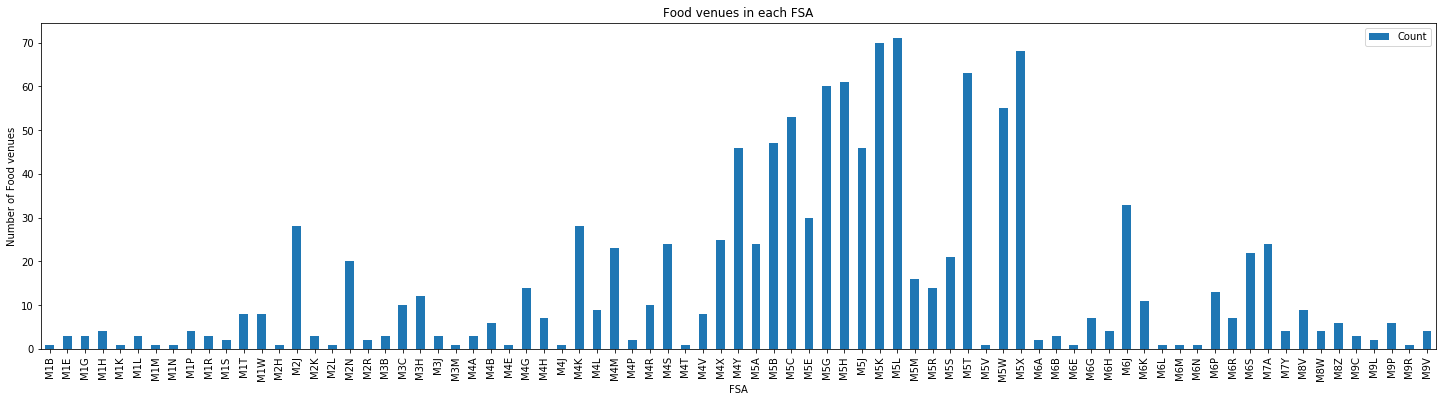

In [14]:
food_count = foods[['FSA','Venue Category']].groupby('FSA').count().rename(columns={"Venue Category":"Count"})

food_count.plot(kind='bar', figsize=(25, 6))

plt.xlabel('FSA') # add to x-label to the plot
plt.ylabel('Number of Food venues') # add y-label to the plot
plt.title('Food venues in each FSA') # add title to the plot

plt.show()

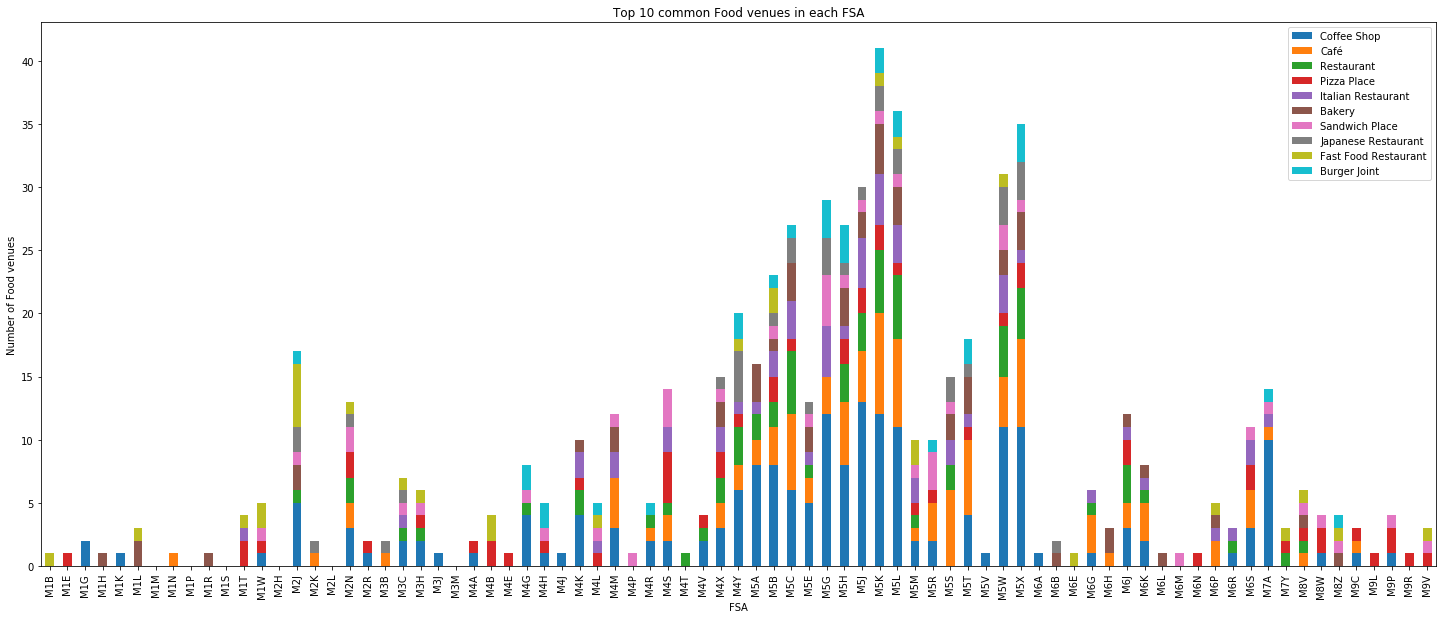

In [15]:
food_cat.plot(kind='bar', stacked = True, figsize=(25, 10))

plt.xlabel('FSA') # add to x-label to the plot
plt.ylabel('Number of Food venues') # add y-label to the plot
plt.title('Top 10 common Food venues in each FSA') # add title to the plot

plt.show()

### Geographical location of food venues on map

In [16]:
map = folium.Map(location=[43.722622, -79.383561], zoom_start=11, min_zoom = 11, max_zoom = 11, width = 1200, height = 800)

# instantiate a feature group for the food venue in the dataframe
foodvenue = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(foods['Venue Latitude'], foods['Venue Longitude']):
    foodvenue.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
# add incidents to map
map.add_child(foodvenue)

In [17]:
map = folium.Map(location=[43.722622, -79.383561], zoom_start=11, width = 1200, height = 800)

from folium import plugins

# instantiate a mark cluster object for the food venue in the dataframe
foodvenue = plugins.MarkerCluster().add_to(map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(foods['Venue Latitude'], foods['Venue Longitude'], foods['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(foodvenue)

# display map
map

## 2.3 Population and number of food venues

### Population in each FSA

In [18]:
map = folium.Map(location=[43.722622, -79.383561], zoom_start=11, min_zoom = 11, max_zoom = 11, width = 1200, height = 800)
geo = "toronto.geojson"
map.choropleth(
    geo_data = geo,
    data = df,
    columns=['FSA','Population'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population by FSA')   
map

### Population and food venues in each FSA

In [19]:
map = folium.Map(location=[43.722622, -79.383561], zoom_start=11, min_zoom = 11, max_zoom = 11, width = 1200, height = 800)
geo = "toronto.geojson"
map.choropleth(
    geo_data = geo,
    data = df,
    columns=['FSA','Population'],
    key_on='feature.properties.CFSAUID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population by FSA')   

# instantiate a mark cluster object for the food venue in the dataframe
foodvenue = plugins.MarkerCluster().add_to(map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(foods['Venue Latitude'], foods['Venue Longitude'], foods['Venue Category']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(foodvenue)
    
map

# 3. Regression Analysis

### Analysing relationship between population and number of restaurant

In [20]:
regression_df = pd.merge(df[['FSA','Population']], food_count.reset_index(), on='FSA').rename(columns={"Count":"Venue_no"})

print('dataframe: regression_df,   shape:', regression_df.shape)
regression_df.head(3)

dataframe: regression_df,   shape: (79, 3)


FSA  Population  Venue_no
0  M1B       66108         1
1  M1E       46943         3
2  M1G       29690         3

[Text(0, 0.5, 'Number of Venues'), Text(0.5, 0, 'Population')]

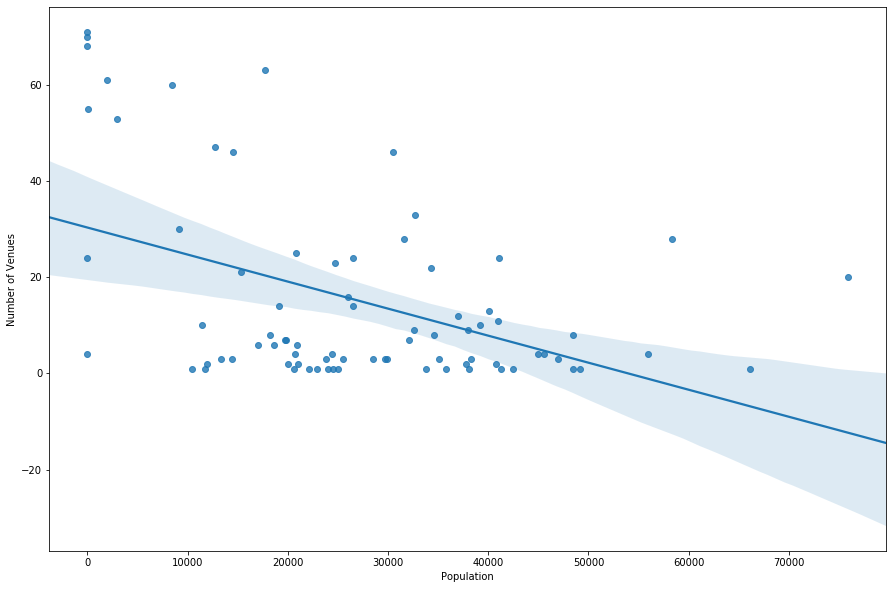

In [21]:
plt.figure(figsize=(15, 10))
ax = sns.regplot(x='Population', y='Venue_no', data=regression_df)
ax.set(xlabel='Population', ylabel='Number of Venues')

# 4. Clustering with k-means


### Prepare Clusters

In [22]:
# set number of clusters
kclusters = 4

food_cluster = food_grouped.drop('FSA', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(food_cluster)

# add clustering labels
FSA_top_venue.insert(0, 'Cluster Labels', kmeans.labels_)

df_cluster = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_cluster = df_cluster.join(FSA_top_venue.set_index('FSA'), on='FSA')
df_cluster.dropna(inplace = True)
df_cluster['Cluster Labels'] = pd.to_numeric(df_cluster['Cluster Labels'], downcast='integer')

print('dataframe: df_cluster,   shape:', df_cluster.shape)
df_cluster.head(3)

dataframe: df_cluster,   shape: (79, 16)


FSA      Borough  Population   Latitude  Longitude  Cluster Labels  \
0  M1B  Scarborough       66108  43.806686 -79.194353               0   
2  M1E  Scarborough       46943  43.763573 -79.188711               3   
3  M1G  Scarborough       29690  43.770992 -79.216917               2   

       Top 1 Food Venue   Top 2 Food Venue             Top 3 Food Venue  \
0  Fast Food Restaurant        Wings Joint  Eastern European Restaurant   
2    Mexican Restaurant        Pizza Place               Breakfast Spot   
3           Coffee Shop  Korean Restaurant                  Wings Joint   

              Top 4 Food Venue Top 5 Food Venue Top 6 Food Venue  \
0                 Cupcake Shop    Deli / Bodega     Dessert Shop   
2  Eastern European Restaurant     Cupcake Shop    Deli / Bodega   
3  Eastern European Restaurant    Deli / Bodega     Dessert Shop   

  Top 7 Food Venue  Top 8 Food Venue  Top 9 Food Venue    Top 10 Food Venue  
0            Diner  Doner Restaurant        Donut Shop  Dumpling Restaurant  
2     Dessert Shop             Diner  Doner Restaurant           Donut Shop  
3            Diner  Doner Restaurant        Donut Shop  Dumpling Restaurant

### Visualization of clusters on map

In [23]:
# create map
map_clusters = folium.Map(location=[43.722622, -79.383561], zoom_start=11, min_zoom = 11, max_zoom = 11, width = 1200, height = 800)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster['Latitude'], df_cluster['Longitude'], df_cluster['FSA'], df_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [24]:
df_cluster.loc[df_cluster['Cluster Labels'] == 0, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

Borough  Cluster Labels      Top 1 Food Venue Top 2 Food Venue  \
0   Scarborough               0  Fast Food Restaurant      Wings Joint   
74         York               0  Fast Food Restaurant      Wings Joint   

               Top 3 Food Venue Top 4 Food Venue Top 5 Food Venue  \
0   Eastern European Restaurant     Cupcake Shop    Deli / Bodega   
74  Eastern European Restaurant     Cupcake Shop    Deli / Bodega   

   Top 6 Food Venue Top 7 Food Venue  Top 8 Food Venue Top 9 Food Venue  \
0      Dessert Shop            Diner  Doner Restaurant       Donut Shop   
74     Dessert Shop            Diner  Doner Restaurant       Donut Shop   

      Top 10 Food Venue  
0   Dumpling Restaurant  
74  Dumpling Restaurant

### Cluster 2

In [25]:
df_cluster.loc[df_cluster['Cluster Labels'] == 1, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

Borough  Cluster Labels             Top 1 Food Venue  \
4         Scarborough               1          Fried Chicken Joint   
7         Scarborough               1                       Bakery   
8         Scarborough               1          American Restaurant   
9         Scarborough               1                         Café   
10        Scarborough               1            Indian Restaurant   
11        Scarborough               1                       Bakery   
12        Scarborough               1    Latin American Restaurant   
13        Scarborough               1                  Pizza Place   
15        Scarborough               1         Fast Food Restaurant   
17         North York               1     Mediterranean Restaurant   
18         North York               1                  Coffee Shop   
19         North York               1           Chinese Restaurant   
20         North York               1                    Cafeteria   
22         North York               1                  Coffee Shop   
26         North York               1         Caribbean Restaurant   
27         North York               1             Asian Restaurant   
28         North York               1                  Coffee Shop   
29         North York               1                  Coffee Shop   
32         North York               1                   Food Truck   
38          East York               1                  Coffee Shop   
39          East York               1                 Burger Joint   
41       East Toronto               1             Greek Restaurant   
42       East Toronto               1            Fish & Chips Shop   
43       East Toronto               1                         Café   
45    Central Toronto               1               Sandwich Place   
46    Central Toronto               1                  Coffee Shop   
47    Central Toronto               1                  Pizza Place   
48    Central Toronto               1                   Restaurant   
49    Central Toronto               1                  Coffee Shop   
51   Downtown Toronto               1                  Coffee Shop   
52   Downtown Toronto               1                  Coffee Shop   
53   Downtown Toronto               1                  Coffee Shop   
54   Downtown Toronto               1                  Coffee Shop   
55   Downtown Toronto               1                  Coffee Shop   
56   Downtown Toronto               1                  Coffee Shop   
57   Downtown Toronto               1                  Coffee Shop   
58   Downtown Toronto               1                  Coffee Shop   
59   Downtown Toronto               1                  Coffee Shop   
60   Downtown Toronto               1                  Coffee Shop   
61   Downtown Toronto               1                  Coffee Shop   
62         North York               1                  Coffee Shop   
65    Central Toronto               1               Sandwich Place   
66   Downtown Toronto               1                         Café   
67   Downtown Toronto               1                         Café   
69   Downtown Toronto               1                  Coffee Shop   
70   Downtown Toronto               1                  Coffee Shop   
71         North York               1        Vietnamese Restaurant   
72         North York               1             Asian Restaurant   
75   Downtown Toronto               1                         Café   
76       West Toronto               1                       Bakery   
77       West Toronto               1             Asian Restaurant   
78       West Toronto               1                         Café   
79         North York               1                       Bakery   
80               York               1               Sandwich Place   
82       West Toronto               1           Mexican Restaurant   
83       West Toronto               1  Eastern European Restaurant   
84       West Toronto   

### Cluster 3

In [26]:
df_cluster.loc[df_cluster['Cluster Labels'] == 2, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

Borough  Cluster Labels Top 1 Food Venue   Top 2 Food Venue  \
3        Scarborough               2      Coffee Shop  Korean Restaurant   
6        Scarborough               2      Coffee Shop        Wings Joint   
40         East York               2      Coffee Shop        Wings Joint   
68  Downtown Toronto               2      Coffee Shop        Wings Joint   

    Top 3 Food Venue             Top 4 Food Venue Top 5 Food Venue  \
3        Wings Joint  Eastern European Restaurant    Deli / Bodega   
6   Cuban Restaurant                Deli / Bodega     Dessert Shop   
40  Cuban Restaurant                Deli / Bodega     Dessert Shop   
68  Cuban Restaurant                Deli / Bodega     Dessert Shop   

   Top 6 Food Venue  Top 7 Food Venue  Top 8 Food Venue     Top 9 Food Venue  \
3      Dessert Shop             Diner  Doner Restaurant           Donut Shop   
6             Diner  Doner Restaurant        Donut Shop  Dumpling Restaurant   
40            Diner  Doner Restaurant        Donut Shop  Dumpling Restaurant   
68            Diner  Doner Restaurant        Donut Shop  Dumpling Restaurant   

              Top 10 Food Venue  
3           Dumpling Restaurant  
6   Eastern European Restaurant  
40  Eastern European Restaurant  
68  Eastern European Restaurant

### Cluster 4

In [27]:
df_cluster.loc[df_cluster['Cluster Labels'] == 3, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

Borough  Cluster Labels     Top 1 Food Venue      Top 2 Food Venue  \
2    Scarborough               3   Mexican Restaurant           Pizza Place   
24    North York               3          Coffee Shop           Pizza Place   
34    North York               3          Coffee Shop           Pizza Place   
35     East York               3          Pizza Place  Fast Food Restaurant   
37  East Toronto               3          Pizza Place           Wings Joint   
81          York               3          Pizza Place           Wings Joint   
88     Etobicoke               3          Pizza Place           Coffee Shop   
95    North York               3  Empanada Restaurant           Pizza Place   
98     Etobicoke               3          Pizza Place        Sandwich Place   
99     Etobicoke               3          Pizza Place           Wings Joint   

               Top 3 Food Venue             Top 4 Food Venue  \
2                Breakfast Spot  Eastern European Restaurant   
24                  Wings Joint  Eastern European Restaurant   
34        Portuguese Restaurant          Dumpling Restaurant   
35                    Gastropub               Breakfast Spot   
37  Eastern European Restaurant                 Cupcake Shop   
81  Eastern European Restaurant                 Cupcake Shop   
88               Sandwich Place                 Cupcake Shop   
95  Eastern European Restaurant                 Cupcake Shop   
98                  Coffee Shop           Chinese Restaurant   
99  Eastern European Restaurant                 Cupcake Shop   

             Top 5 Food Venue             Top 6 Food Venue  \
2                Cupcake Shop                Deli / Bodega   
24              Deli / Bodega                 Dessert Shop   
34               Cupcake Shop                Deli / Bodega   
35                Wings Joint  Eastern European Restaurant   
37              Deli / Bodega                 Dessert Shop   
81              Deli / Bodega                 Dessert Shop   
88              Deli / Bodega                 Dessert Shop   
95              Deli / Bodega                 Dessert Shop   
98  Middle Eastern Restaurant          Filipino Restaurant   
99              Deli / Bodega                 Dessert Shop   

        Top 7 Food Venue  Top 8 Food Venue  Top 9 Food Venue  \
2           Dessert Shop             Diner  Doner Restaurant   
24                 Diner  Doner Restaurant        Donut Shop   
34          Dessert Shop             Diner  Doner Restaurant   
35         Deli / Bodega      Dessert Shop             Diner   
37                 Diner  Doner Restaurant        Donut Shop   
81                 Diner  Doner Restaurant        Donut Shop   
88                 Diner  Doner Restaurant        Donut Shop   
95                 Diner  Doner Restaurant        Donut Shop   
98  Fast Food Restaurant      Cupcake Shop        Food Court   
99                 Diner  Doner Restaurant        Donut Shop   

      Top 10 Food Venue  
2            Donut Shop  
24  Dumpling Restaurant  
34           Donut Shop  
35     Doner Restaurant  
37  Dumpling Restaurant  
81  Dumpling Restaurant  
88  Dumpling Restaurant  
95  Dumpling Restaurant  
98                 Food  
99  Dumpling Restaurant